# *Library*
Import *library* yang dibutuhkan.

In [1]:
!pip3 install num2words # Install library untuk mengubah angka menjadi kata.
!pip install Sastrawi # Karena wordnet tidak bisa digunakan maka di sini pakai Sastrawi.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.5 MB/s eta 0:00:00


In [2]:
# Library untuk membaca file .csv.
import pandas as pd
# Library untuk visualisasi.
import matplotlib.pyplot as plt
import seaborn as sns
# Library untuk memproses teks.
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.text import one_hot
from num2words import num2words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# Library untuk membangun model.
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import numpy as np
# Library untuk memisahkan dataset.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Library untuk evaluasi model.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Library untuk path
import pathlib
# Library untuk utilitas tensorflow
import tensorflow as tf
# Library untuk glob
import glob

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
nltk.download('punkt') # Untuk tokenizer kata.
nltk.download('stopwords')# Untuk menghapus stopwords.
# nltk.download('wordnet') # Ada masalah ketika menggunakan wordnet.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Membaca Dataset
Melakukan visualisasi dataset yang dimiliki.

In [4]:
df = pd.read_csv('/kaggle/input/dataset/dataset.csv')
print(df.head())

                                             text_id  is_depression
0  mungkin kau selalu menduga diriku tidak pernah...              1
1  aku tidak kehilangan seorang teman pun aku han...              1
2  manusia tidak akan pernah selesai dengan selur...              0
3  aku menyesal bahwa selama ini aku tidak pernah...              0
4  jangan pernah merasa sendiri lihatlah aku yang...              1


In [5]:
# df = pd.read_csv("/kaggle/input/data-mh-id/data_mh.csv", delimiter=",") # Sesuaikan `delimiter` berdasarkan bahasa yang digunakan dalma .csv.
# df.head()

Visualisasi label, usahakan label yang dimiliki seimbang.

<Axes: >

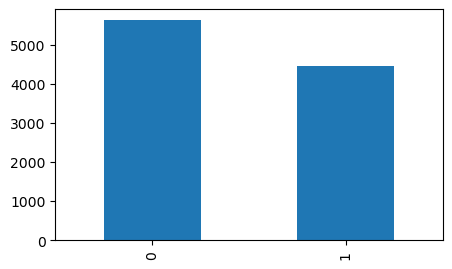

In [6]:
df["is_depression"].value_counts().plot(kind="bar",figsize=(5,3))

In [7]:
# Cek apakah terdapat null value atau tidak.
print(df.isnull().sum())

text_id          0
is_depression    0
dtype: int64


In [8]:
# Cek tipe data kolom.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10082 entries, 0 to 10081
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_id        10082 non-null  object
 1   is_depression  10082 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.7+ KB
None


# Memproses Data Teks
Proses data teks seperti menghapus `stop_words`, menjadikannya kata dasar, mengganti angka ke dalam teks, dll.

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

### def translate_test lebih baik diskip translate via spreadsheet aja
# def translate_text(text):
#     url = "https://translate.googleapis.com/translate_a/single?client=gtx&sl=en&tl=id&dt=t&q={}".format(text)
#     response = requests.get(url)
#     result = response.json()[0][0][0]
#     return result

def preprocess_text(text):
#     text = translate_text(text) # Kemudian di sini kita coba translate
    text = word_tokenize(text.lower()) # Tokenize text_id ke dalam token/kata
    text = [t for t in text if t not in stop_words] # Hapus stop_words
    text = [stemmer.stem(t) for t in text] # Menjadikan kata dasar
    text = [t if not t.isdigit() else num2words(int(t)) for t in text] # Mengganti angka ke teks
#     text = emoji.demojize(text) # ubah emoji ke dalam bentuk teks
#     text = re.sub(r':[a-z_]+:', lambda m: ' '.join(m.group(0).replace(':', '').split('_')), text) # Regex misal emoji: 🎉 bakal diubah jadi "party popper".
    text = ' '.join(text) # Gabungkan ke dalam teks kembali
    return text

In [10]:
df = df[pd.notnull(df['text_id'])] # hapus semua baris dengan nilai NaN di kolom `text`
df = df[df['text_id'].apply(lambda x: isinstance(x, str))] # hapus semua baris di mana `text` bukan string
df['nlp_text'] = df['text_id'].apply(lambda x: preprocess_text(x))

In [11]:
df.head()

,text_id,is_depression,nlp_text
0,mungkin kau selalu menduga diriku tidak pernah...,1,kau duga diri paham kau curiga dua cinta
1,aku tidak kehilangan seorang teman pun aku han...,1,hilang teman sadar milik
2,manusia tidak akan pernah selesai dengan selur...,0,manusia selesai tengkar dendam benci bully cac...
3,aku menyesal bahwa selama ini aku tidak pernah...,0,sesal berani lang syukur sama orang dorong ber...
4,jangan pernah merasa sendiri lihatlah aku yang...,1,lihat pergi usaha saat sedih terkadang jauh se...


# Hitung Ukuran *Vocabulary*
Memasukan kata unik ke dalam *set* `words`, kemudian untuk menghitung ukuran *vocabulary*.

In [12]:
words = set(word for sentence in df["nlp_text"] for word in sentence.split())
vocab_size = len(words)
print(vocab_size)

7043


# *One Hot Encoding* untuk Setiap Kalimat
*One-hot encode* teks ke dalam daftar indeks kata berukuran n.

In [13]:
one_hot_representation = [one_hot(words,vocab_size) for words in df["nlp_text"]] # Input teksnya `words` di setiap `df["nlp_text"]` dengan ukuran `vocab_size`
# one_hot_representation

Cari panjang maksimum untuk dimasukan ke dalam word embeddings.

In [14]:
max_len = 0
for elem in one_hot_representation:
    if len(elem) > max_len:
        max_len = len(elem)
max_len

44

# Mengonversi *One-hot Encodings* ke *Word Embeddings*
Meskipun *one-hot encodings* adalah teknik yang berguna untuk merepresentasikan kata-kata sebagai vektor numerik di NLP, teknik ini memiliki beberapa keterbatasan. Salah satunya adalah vektor *one-hot* berdimensi tinggi dan *sparse*, yang berarti bahwa sebagian besar elemen vektor adalah 0, yang dapat mempersulit algoritma pembelajaran mesin untuk mengekstraksi pola yang bermakna dari data.
Untuk mengatasi keterbatasan ini, kita dapat mengonversi vektor *one-hot* menjadi *word embeddings*, yaitu vektor yang sifatnya *dense* berdimensi rendah yang merepresentasikan kata dalam ruang vektor kontinu.

Ketika panjang sequences kurang dari max_length maka pad_sequences akan menambahkan padding supaya jumlahnya sama dengan max_length. padding = 'post' dibuat untuk menambahkan padding di akhir, jika padding = 'pre' maka padding akan ditambahkan di awal sequences.

Kemudian apabila panjang sequences lebih dari max_length maka akan ditruncate. padding = 'post' dibuat untuk truncate di akhir, jika padding = 'pre' maka dibuat untuk truncate di awal.

In [15]:
# embedded_docs = pad_sequences(one_hot_representation, padding='pre', maxlen = max_len)
embedded_docs = pad_sequences(one_hot_representation, padding = 'post',truncating = 'post', maxlen = max_len)

In [16]:
### Model 1
# embedding_vector_features = max_len * 2
# model = Sequential()
# model.add(Embedding(14233, embedding_vector_features, input_length=max_len))
# model.add((LSTM(100)))
# model.add(Dense(1,activation = 'sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# print(model.summary())

In [17]:
# ### Model 2
# embedding_dim = 100
# model = Sequential()
# model.add(Embedding(input_dim=16042, output_dim=embedding_dim, input_length=max_len))
# model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [ ]:
y = df["is_depression"]

Jumlah sample `y` dengan `embedded_docs` harus sama.

In [ ]:
print(f"Shape of y is: {y.shape}")
print(f"Shape of embedded document is: {embedded_docs.shape}")

# *Split* Dataset

Di sini kita split `test_size` sebesar 0.1 dikarenakan jumlah datasetnya berukuran besar. Kemudian menggunakan `stratifikasi` dalam fungsi `train_test_split()` memastikan bahwa `training set` dan `test set` memiliki distribusi sampel yang proporsional dari setiap label kelas dalam variabel target, yang dapat membantu jika set data tidak seimbang.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embedded_docs, y, test_size = 0.1, random_state = 42, stratify = y)

In [ ]:
# Split data ke dalam training set dan test set (90% training data, 10% test data)
X_train_val, X_test, y_train_val, y_test = train_test_split(embedded_docs, y, test_size=0.1, random_state=42, stratify=y)

# Split data training set yang tersisa ke dalam training set dan validation set (80% training data, 20% validation data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

Setelah membagi data, kita dapat menggunakan `X_train`, `y_train` untuk melatih model, `X_val`, `y_val` untuk penyetelan *hyperparameter*, dan `X_test`, `y_test` untuk mengevaluasi kinerja akhir dari model yang dilatih.

In [ ]:
print(f"Shape of X train is: {X_train.shape}")
print(f"Shape of y train is: {y_train.shape}")
print(f"Shape of X test is: {X_val.shape}")
print(f"Shape of y test is: {y_val.shape}")
print(f"Shape of X test is: {X_test.shape}")
print(f"Shape of y test is: {y_test.shape}")

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=3,batch_size=16) # Kayanya epoch cukup di 3 aja

#### Kalau ga cukup coba pakai chunking (tapi usahain batch_size jangan besar2 nanti abis memori)
# chunk_size = 1000  # ukuran setiap chunk
# # shuffle data
# X_train, y_train = shuffle(X_train, y_train)
# # loop melalui data di dalam chunks
# for i in range(0, len(X_train), chunk_size):
#     X_chunk = X_train[i:i+chunk_size]
#     y_chunk = y_train[i:i+chunk_size]  
#     # train model terhadap chunk yang sekarang
#     model.fit(X_chunk, y_chunk, epochs=1, batch_size=32, validation_data=(X_test, y_test))

# Prediksi Model dengan `X_val`

In [ ]:
y_pred = model.predict(X_val)

Probabilitas lebih besar dari atau sama dengan 0.5 akan diberikan ke kelas positif.

In [ ]:
y_pred = (y_pred >= 0.5).astype("int")

In [ ]:
print(classification_report(y_val,y_pred))
print(confusion_matrix(y_val,y_pred))

In [ ]:
y_val = y_val.reset_index(drop = True).values # Reset index `y_val` supaya dari 0 lagi sebelum dikonversi ke dalam array

In [ ]:
for i in range(len(y_val)):
    print("True label: {}, Predicted label: {}".format(y_val[i], y_pred[i]))

In [ ]:
h = history.history
print(h.keys())

In [ ]:
# Plot fungsi loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Plot akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Prediksi Model dengan `X_test`

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
y_pred_test = (y_pred_test >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test,y_pred_test))
print(confusion_matrix(y_test,y_pred_test))

In [ ]:
y_test = y_test.reset_index(drop = True).values # Reset index `y_test` supaya dari 0 lagi sebelum dikonversi ke dalam array

In [ ]:
for i in range(len(y_test)):
    print("True label: {}, Predicted label: {}".format(y_test[i], y_pred_test[i]))

# Simpan Model

In [ ]:
model.save('model.h5')

# Convert to TFLite

In [ ]:
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tf_lite_model = converter.convert()

# # Save model
# tflite_model_file = pathlib.Path("/kaggle/working/model.tflite")
# tflite_model_file.write_bytes(tf_lite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tf_lite_model = converter.convert()

tflite_model_file = pathlib.Path("/kaggle/working/model.tflite")
tflite_model_file.write_bytes(tf_lite_model)